 # DQN Training in Maze Environment (Hyperparameterized)

In [1]:
import maze_library
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from collections import deque
import random
import itertools
from collections import deque


 ## Hyperparameters

In [2]:
hyperparams = {
    "learning_rate":5e-6,
    "gamma": 0.98,
    "epsilon_decay_episodes": 0.9,
    "batch_size": 256,
    "replay_buffer_size": 10000,
    "episodes": 2000,
    "hidden_layers": 
        [256, 256, 256] 
    ,
    "activation": "elu",
    "attempts_per_episode": 10,
    "epsilon_start": 1.0,
    "epsilon_min": 0.01,
    "replay_buffer_size": 10000,
    "steps_per_episode": 2000,
    "target_update_freq": 500,
    "random_seed": 42,
    "maze_width": 10,
    "maze_height": 10,
    "maze_imperfections": 5,
    "input_dim": 19,
    "n_outputs": 4,
    "log_every": 1,
    "q_log_every": 2000,
    "plot_every": 1100,
    "train_after": 0.33333,
    "truncate_after": 100,
    "target_dqn_update" : 50
}


# Constants

In [3]:
random_seed = 42
maze_width = 16
maze_height = 16
input_shape = 19
n_outputs = 4



 ## Maze Setup

In [4]:
np.random.seed(random_seed)

env = maze_library.init_environment(maze_width, maze_height, allowed_revisits=hyperparams["truncate_after"])
maze_library.make_maze_imperfect(env)


In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 ## Model Definition

In [6]:
activation_map = {
    "relu": nn.ReLU,
    "elu": nn.ELU,
    "tanh": nn.Tanh,
    "sigmoid": nn.Sigmoid,
    # Add more if needed
}

class DQN(nn.Module):
    def __init__(self, input_size, output_size,device, hidden_layers=[64, 64, 64], activation="elu", ):
        super(DQN, self).__init__()
        self.model = nn.Sequential()
        self.device = device
        prev_size = input_size
        for i, hidden_size in enumerate(hidden_layers):
            self.model.add_module(f"fc{i}", nn.Linear(prev_size, hidden_size))
            self.model.add_module(f"act{i}", activation_map[activation]())
            prev_size = hidden_size
        
        self.model.add_module("output", nn.Linear(prev_size, output_size))

    def forward(self, x):
        return self.model(x)


def create_double_dqn_model(hyperprm):
    model = DQN(input_shape, n_outputs, DEVICE, hyperprm["hidden_layers"], hyperprm["activation"])
    target_model = DQN(input_shape, n_outputs, DEVICE, hyperprm["hidden_layers"], hyperprm["activation"])
    target_model.load_state_dict(model.state_dict())  # Initialize target model with the same weights
    optimizer = torch.optim.NAdam(model.parameters(), lr=5e-5)
    loss_fn = nn.HuberLoss()

    return model, target_model, optimizer, loss_fn


 ## Policy and Replay Buffer

In [7]:
class ExperienceReplayBuffer:
    def __init__(self, capacity, state_shape):
        self.capacity = capacity
        self.state_shape = state_shape

        self.states = np.empty((capacity, *state_shape), dtype=np.float32)
        self.actions = np.empty((capacity,), dtype=np.int64)
        self.rewards = np.empty((capacity,), dtype=np.float32)
        self.next_states = np.empty((capacity, *state_shape), dtype=np.float32)
        self.dones = np.empty((capacity,), dtype=bool)
        self.truncateds = np.empty((capacity,), dtype=bool)

        self.size = 0
        self.ptr = 0

    def append(self, state, action, reward, next_state, done, truncated):
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.next_states[self.ptr] = next_state
        self.dones[self.ptr] = done
        self.truncateds[self.ptr] = truncated

        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        idxs = np.random.randint(0, self.size, size=batch_size)

        batch = dict(
            state=self.states[idxs],
            action=self.actions[idxs],
            reward=self.rewards[idxs],
            next_state=self.next_states[idxs],
            done=self.dones[idxs],
            truncated=self.truncateds[idxs]
        )

        return batch

    def __len__(self):
        return self.size


In [8]:

def epsilon_greedy_policy(state, epsilon, model):
    if random.random() < epsilon:
        return random.randint(0, n_outputs - 1)
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        q_values = model(state_tensor)
        return int(torch.argmax(q_values).item())



In [9]:


def play_one_step(env, state, epsilon,model, replay_buffer, reward_log, run):
    action = epsilon_greedy_policy(state, epsilon, model)
    action_obj = maze_library.create_action(action, run)
    next_state, reward, done, truncated = env.take_action(action_obj)
    reward_log.append(reward)
    replay_buffer.append(state, action, reward, next_state, done, truncated)
    return next_state, reward, done, truncated


In [10]:


def training_step(model,target_model ,optimizer, loss_fn, hyperprm, replay_buffer, q_value_log):
    sample = replay_buffer.sample(hyperprm["batch_size"])
    states = torch.tensor(sample["state"], dtype=torch.float32)
    actions = torch.tensor(sample["action"], dtype=torch.int64)
    rewards = torch.tensor(sample["reward"], dtype=torch.float32)
    next_states = torch.tensor(sample["next_state"], dtype=torch.float32)
    dones = torch.tensor(sample["done"], dtype=torch.float32)
    truncateds = torch.tensor(sample["truncated"], dtype=torch.float32)

    with torch.no_grad():
        next_q_values = model(next_states)
        next_actions = next_q_values.argmax(dim=1)
        target_q_values = target_model(next_states)
        max_next_q = target_q_values.gather(1, next_actions.unsqueeze(1)).squeeze()
        
        terminal = torch.logical_or(dones.bool(), truncateds.bool()).float()
        target_q = rewards + (1 - terminal) * hyperprm["gamma"] * max_next_q

    q_values = model(states)
    selected_q = q_values.gather(1, actions.unsqueeze(1)).squeeze()
    loss = loss_fn(selected_q, target_q)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    q_value_log.extend(Tensor.cpu(selected_q.detach()).numpy())


In [11]:
def plot_q_values(q_value_log):
    plt.figure(figsize=(10, 5))
    plt.plot(q_value_log)
    plt.title("Q-Values Over Time")
    plt.xlabel("Training Steps")
    plt.ylabel("Q-Value")
    plt.grid(True)
    plt.show()


 ## Training Loop

In [ ]:
def run_single_experiment(hyperprm, run_id):
    all_episode_rewards  = []
    reward_log = []
    q_value_log = []
    target_weights = None
    model,target_model, optimizer, loss_fn = create_double_dqn_model(hyperprm)
    replay_buffer = ExperienceReplayBuffer(capacity=hyperprm["replay_buffer_size"], state_shape=(input_shape,))
    print(f"Run {run_id}, Episodes: {hyperprm['episodes']}")

    for episode in range(hyperprm["episodes"]):
        obs = env.reset_and_regenerate()
        cumulative_reward = 0
        eps_decay = episode / (hyperprm["episodes"] * hyperprm["epsilon_decay_episodes"])
        epsilon = max(hyperprm["epsilon_start"] - eps_decay, hyperprm["epsilon_min"])
        print(episode)
        for mini_episode in range(hyperprm["attempts_per_episode"]):
            env.reset()
            for _ in range(hyperprm["steps_per_episode"]):
                obs, reward, done, truncated = play_one_step(env, obs, epsilon,model, replay_buffer, reward_log, mini_episode)
                cumulative_reward += reward * (mini_episode/hyperprm["attempts_per_episode"])
                if done or truncated:
                    break
            
        if episode > (hyperprm["episodes"] * hyperprm["train_after"]):
            training_step(model,target_model ,optimizer, loss_fn, hyperprm, replay_buffer, q_value_log, )
        
        if episode > hyperprm["target_dqn_update"]:
            target_model.load_state_dict(model.state_dict())
        score = maze_library.get_score(env)
        if episode % hyperprm["log_every"] == 0 and episode != 0:
            print(f"Run {run_id}, Total steps {score.total_steps},Best run {score.best_run_steps} Reward: {np.average(all_episode_rewards[-50:])} Episode: {episode}")
        with open(f'../mazeLogs/doubledqn{episode}.json', 'w') as file:
            file.write(env.to_json_python())
        # if episode % hyperprm["q_log_every"] == 0 and episode > 0:
        #REWARDS NEEDS TO BE CHANGES
        all_episode_rewards.append(cumulative_reward)
    
    plot_q_values(q_value_log)

    return {
        "params": hyperprm,
        "rewards": all_episode_rewards,
        "score" : maze_library.get_score(env),
        "q_values": q_value_log,
        "final_model": model,
    }


In [13]:
results = []
number_of_iterations = 20
for i in range(number_of_iterations):
    results.append(run_single_experiment(hyperparams, run_id=i))
    

Run 0, Episodes: 2000
0
1


AttributeError: 'int' object has no attribute 'total_steps'

 ## Evaluation

In [ ]:
def get_changed_hyperparams(defaults, current):
    return {
        k: v for k, v in current.items()
        if k not in defaults or defaults[k] != v
    }

NameError: name 'get_changed_hyperparams' is not defined

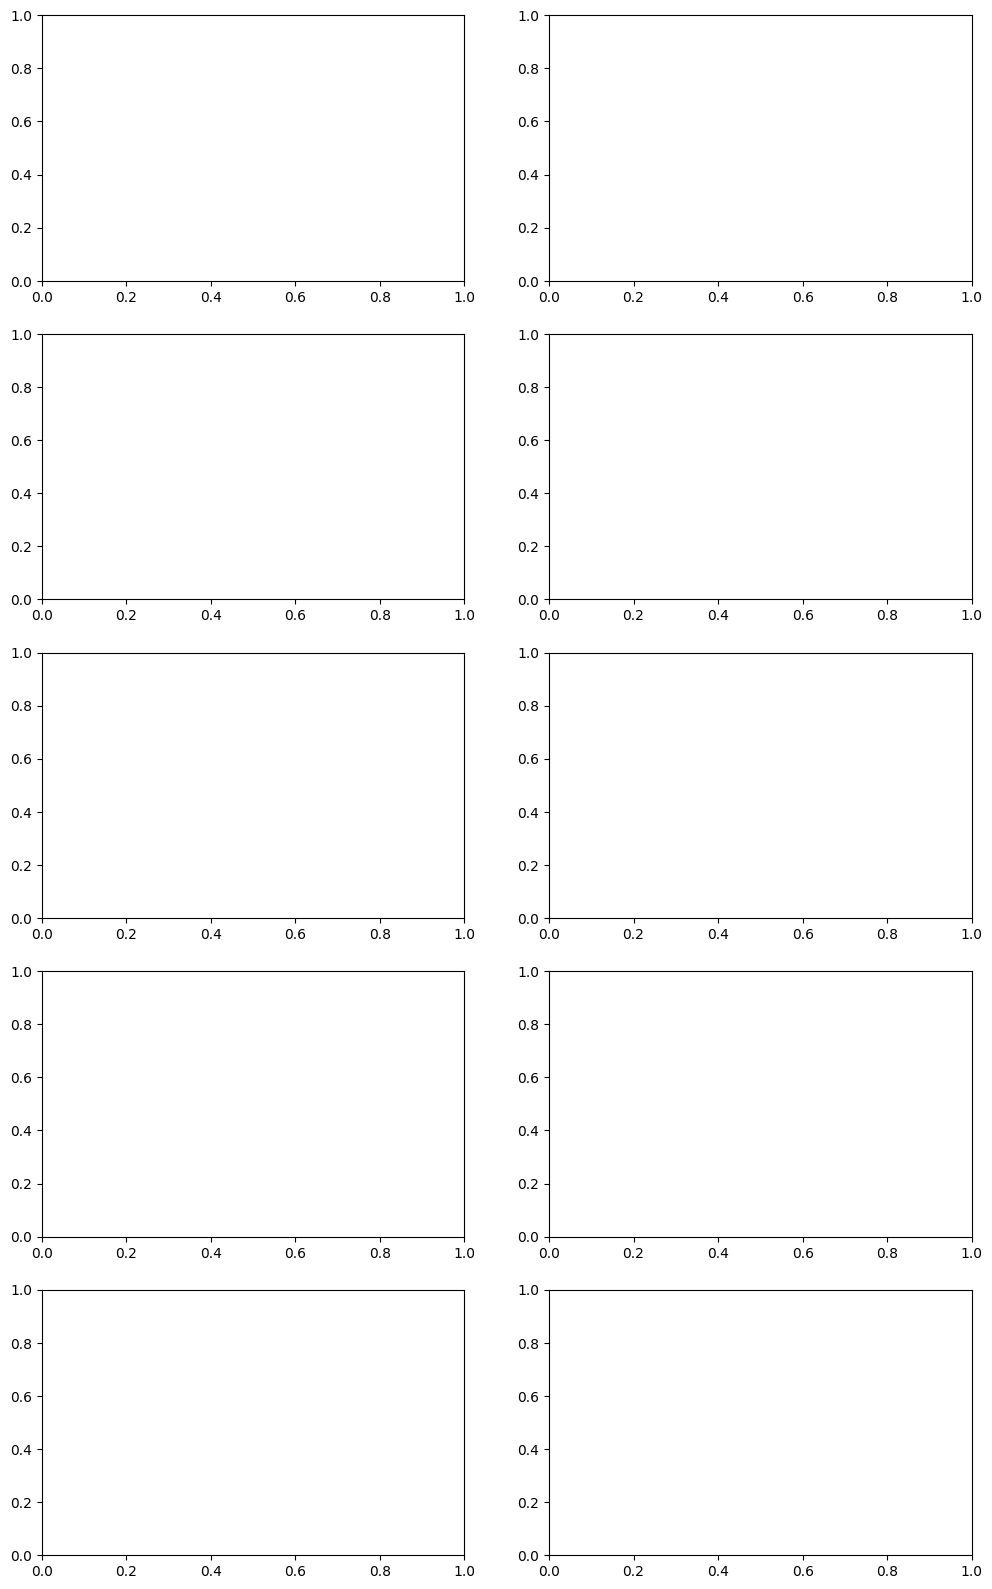

In [ ]:
import math
import matplotlib.pyplot as plt

cols = 2
rows = math.ceil(len(results) / cols)

fig, axs = plt.subplots(rows, cols, figsize=(12, rows * 4))

if len(results) == 1:
    axs = [axs]

# Step 1: Find the max absolute reward for symmetric y-axis
max_reward = max(
    max(abs(min(result["rewards"])), abs(max(result["rewards"])))
    for result in results
)

# Round up to make the graph cleaner
y_limit = math.ceil(max_reward)

for i, result in enumerate(results):
    ax = axs[i // cols][i % cols] if rows > 1 else axs[i % cols]

    rewards = result["rewards"]
    changed = get_changed_hyperparams(shared_params, result["params"])

    ax.plot(rewards)
    ax.set_title(f"Run {i} - Changed Params:")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.grid(True)

    # Step 2: Set a constant center of 0
    ax.set_ylim(-y_limit, y_limit)

    # Annotate changed hyperparameters
    annotation = "\n".join([f"{k}: {v}" for k, v in changed.items()])
    ax.text(1.01, 0.5, annotation, transform=ax.transAxes,
            fontsize=9, verticalalignment='center',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols][j % cols] if rows > 1 else axs[j % cols])

fig.tight_layout()
plt.savefig("comparison_plot2.png")
plt.show()


In [ ]:
import pandas as pd
csv_data = []
for i, result in enumerate(results):
    param_row = {**result["params"]}
    param_row["run_id"] = i
    param_row["mean_reward"] = sum(result["rewards"]) / len(result["rewards"])
    param_row["max_reward"] = max(result["rewards"])
    param_row["min_reward"] = min(result["rewards"])
    csv_data.append(param_row)

df = pd.DataFrame(csv_data)
df.to_csv("results_log2.csv", index=False)
print("Saved results to results_log.csv")

Saved results to results_log.csv


In [ ]:
# plt.figure(figsize=(10, 5))
# plt.hist(reward_log, bins=10, edgecolor='black')
# plt.title("Reward Distribution")
# plt.xlabel("Reward")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.show()
